# Programas generacion de hologramas

Para generar hologramas, se usara un propagador de fresnel de funcion de transferencia. Sea un campo de entrada $U_0 (x,y)$, el campo propagado a una distancia z es dado por 

$$U_z(x',y')=FFT^{-1} [FFT[U_0(x,y)]H_z(v,u)] $$

Este proceso es simplemente una forma rapida de calcular la convolucion de el campo de entrada con $H_z(v,u)$, donde $H_z(v,u)$ es el la funcion de transferencia de fresnel, definida como 

$$H_z(v,u)=e^{jkz}e^{-j\pi \lambda z (v^2 + u^2)}$$

siendo $\lambda$ la longitud de onda, $k$ el numero de onda y $v$, $u$ coordenadas en el espacio de las frecuencias.

Para generar un holograma de fresnel, basta con calcular el campo propagado desde una entrada dada a una distancia determinada.

Posteriormente, se genera una onda plana que incide en el plano z (el mismo al que se propago el campo de entrada) con un angulo determinado. Este se puede generar simplemente con

$$ R(x',y')=e^{-j \pi (cos(\alpha)x'+cos(\beta)y') }$$

donde $\alpha$ y $\beta$ son los angulos que forma el vector de propagacion de la onda plana respecto a la normal al plano de U_z(x',y'). 

Una vez se tiene la onda de referencia, se suma campo propagado con la onda de referencia y se calcula el modulo cuadrado de la suma. Asi

$$ T(x',y')=|U_z(x',y')+R(x',y')|^2 $$

Ese sera el holograma. Para reconstruir basta con realizar la propagacion inversa, usando $H_{-z}$.

En el codigo a continuacion estan la funcion para calcular la funcion de transmitancia y realizar la convolucion con el campo de entrada. 

Se deben elegir unos parametros de tamaño de pixel y longitud de onda para calcular la funcion de transmitancia de fresnel, estos deben cumplir que 

$$  z <= \frac{Mdx^2}{\lambda} $$ 

siendo dx el tamaño de pixel, z la distancia de propagación, y M el tamaño en pixeles del campo de entrada.


Asi el proceso es el siguiente:

1. Cargar una imagen del objeto cuyo holograma se quiere generar.
2. Redimensionarla a la resolucion del holograma que se quiere generar. 
3. Definir un z que cumpla la condicion detallada anteriormente. Recomendacion usar $\lambda= 532 nm$, y $dx=8 \mu m$.
4. Calcular la funcion de transferencia con el programa ftfresnel.
5. Realizar la propagacion de objeto de entrada usando la funcion convft.
6. Generar la onda plana.
7. Sumar el campo propagado y la onda plana.
8. Calcular el modulo cuadrado de esa suma.
9. Guardar el resultado como una imagen (recomendado normalizar en intensidad).

Para informacion sobre el calculo de la propagacion ver "Computational fourier optics" D. Voelz. Para informacion sobre reconstruccion de hologramas ver "Introduction to digital holography" U.Schars. Para informacion sobre simulacion de hologramas ver "Computer-simulated Fresnel holography" Trenter.



In [ ]:
import numpy as np
import scipy.fft as sft
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import pandas as pd
import imageio
import warnings
warnings.filterwarnings('ignore')
import os, sys, shutil
import fnmatch
import imageio.core.util
import random
def silence_imageio_warning(*args, **kwargs):
    pass
imageio.core.util._precision_warn = silence_imageio_warning

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def Reference(M, N, dx, λ, α, β):
    """
    Genera la onda plana de referencia R(x',y')
    """
    k=2*np.pi/λ
    Lx=M*dx
    Ly=N*dx
    x=np.arange(-Lx/2,Lx/2,dx)
    y=np.arange(-Ly/2,Ly/2,dx)
    X, Y = np.meshgrid(x,y)
    R = np.exp(-2j*np.pi*(np.cos(α)*X+np.cos(β)*Y)/dx)
    return R
      
def convft(U,H,dx):
    """
    Realiza la convolucion 2D de las matrices U,H usando la transformada rapida de Fourier. U, H deben tener la misma forma.
    
    Parameters
    ----------
    U : Array Numpy
        Uno de las matrices a convolucionar
    H : Array Numpy
        Otra de las matrices a convolucionar
    dx : Float
        Tamaño de muestreo de las funciones a convolucionar. Necesario para preservar escala.

    Returns
    -------
    U2
        Arreglo de numpy con la convolucio de U y H

    """
    U2=sft.fft2(sft.fftshift(U))*(dx**2)
    U2=H*U2
    U2=sft.ifftshift(sft.ifft2(U2)*(1/dx**2))
    return U2

def circ(x): # FUNCION circulo EN 2D
        s=np.zeros(x.shape)
        s[(x)<1]=1.0
        return s
    

def tajada(M1,M2,x,y):
    """
    Esta funcion permite recortar una seccion centrada en x, y del array M1 de
    tamaño igual al array M2. Las coordenadas x,y son dadas en un sistema cartesiano centrado.

    Parameters
    ----------
    M1 : Array Numpy
        Arreglo del que se recorta una sección.
    M2 : Array Numpy
        Arreglo que determina el tamaño del recorte.
    x : Integer
        Coordenada en x del centro del recorte en un sistema cartesiano centrado para M1.
    y : Integer
        Coordenada en y del centro del recorte en un sistema cartesiano centrado para M1..

    Raises
    ------
    ValueError
        Si el tamaño del area a recortar o las coordenadas exceden el tamaño de la matriz original
        se disparara este error.

    Returns
    -------
    MC
        Arreglo de numpy con forma igual a M2.

    """
    (m,n)=M1.shape
    (mm,nn)=M2.shape
    if mm>m or nn>n:
        raise ValueError('La matriz recortada debe ser mas pequeña que la original')
    MC=M1[np.int32(np.ceil((m-mm)*0.5)+y):np.int32(np.ceil((m+mm)*0.5)+y),np.int32(np.ceil((n-nn)*0.5)+x):np.int32(np.ceil((n+nn)*0.5)+x)]
    return MC

def fusion(M1,M2,x,y):
    """
    Esta funcion permite insertar M2 a una seccion centrada en (x, y) del array M1.
    Las coordenadas x,y son dadas en un sistema cartesiano centrado.

    Parameters
    ----------
    M1 : Array Numpy
        Arreglo al que se inserta una sección.
    M2 : Array Numpy
        Arreglo a insertar.
    x : Integer
        Coordenada en x del centro del recorte en un sistema cartesiano centrado para M1.
    y : Integer
        Coordenada en y del centro del recorte en un sistema cartesiano centrado para M1..

    Raises
    ------
    ValueError
        Si el tamaño del area a insertar o las coordenadas exceden el tamaño de la matriz original
        se disparara este error.

    Returns
    -------
    MC
        Arreglo de numpy con forma igual a M1.

    """
    (m,n)=M1.shape
    (mm,nn)=M2.shape
    if mm>m or nn>n:
        raise ValueError('La matriz a instertar debe ser mas pequeña que la original')
    M1[np.int32(np.ceil((m-mm)*0.5)+y):np.int32(np.ceil((m+mm)*0.5)+y),np.int32(np.ceil((n-nn)*0.5)+x):np.int32(np.ceil((m+nn)*0.5)+x)]=M2
    MC=np.copy(M1)
    return MC

def ftfresnel(M,N,dx,wl,z):
    
    """
    Esta funcion genera una funcion de transferencia  de tamaño (n,m) para la transformada de fresnel
    con distancia z tamaño de píxel dx y longitud de onda wl.
    Usar tamaños cuadrados para evitar artefactos de anisotropia, o generar una funcion cuadrada de mayor tamaño
    y recortar el tamaño deseado. 
    El programa determina si se genera la funcion de transferencia directamente.
    
    Parameters
    ----------
    M : Integer
        Tamaño de la funcion de transferencia en pixeles en la direccion horizontal
    N : Integer
        Tamaño de la funcion de transferencia en pixeles en la direccion horizontal
    dx : Float
        Tamaño de píxel
    wl : Float
        Longitud de onda
    z : Float
        Distancia de propagacion.

    Returns
    -------
    H
        Arreglo de numpy con tamaño N,M

    """
    Lx=M*dx
    Ly=N*dx
    k=2*np.pi/wl
    x=np.arange(-Lx/2,Lx/2,dx)
    y=np.arange(-Ly/2,Ly/2,dx)
    fx=np.arange(-1/(2*dx),1/(2*dx),1/Lx)
    fy=np.arange(-1/(2*dx),1/(2*dx),1/Ly)
    #zmax=(dx*Lx)/wl
    FX,FY=np.meshgrid(fx,fy)
    H=np.exp(-1j*wl*z*np.pi*(FX**2+FY**2))
    H=sft.fftshift(H)
    return H

def irfresnel(M,N,dx,wl,z):
    
    """
    Esta funcion genera una funcion de tranfserencia  de tamaño (n,m) para la transformada de fresnel
    con distancia z tamaño de píxel dx y longitud de onda wl.
    Usar tamaños cuadrados para evitar artefactos de anisotropia, o generar una funcion cuadrada de
    mayor tamaño y recortar el tamaño deseado. 
    El programa genera la funcion de transferencia por medio de la respuesta al impulso con base a
    los parametros introducidos.
    
    Parameters
    ----------
    M : Integer
        Tamaño de la funcion de transferencia en pixeles en la direccion horizontal
    N : Integer
        Tamaño de la funcion de transferencia en pixeles en la direccion horizontal
    dx : Float
        Tamaño de píxel
    wl : Float
        Longitud de onda
    z : Float
        Distancia de propagacion.

    Returns
    -------
    H
        Arreglo de numpy con tamaño N,M

    """
    Lx=M*dx
    Ly=N*dx
    k=2*np.pi/wl
    x=np.arange(-Lx/2,Lx/2,dx)
    y=np.arange(-Ly/2,Ly/2,dx)
    fx=np.arange(-1/(2*dx),1/(2*dx),1/Lx)
    fy=np.arange(-1/(2*dx),1/(2*dx),1/Ly)
    zmax=(dx*Lx)/wl
    X,Y=np.meshgrid(x,y)
    h=(1/(1j*wl*z))*np.exp(1j*k/(2*z)*(X**2+Y**2))
    H=sft.fft2(sft.fftshift(h))*(dx**2)  
    return H

def rename_imgs(folder='data_set/', extension=".jpg"):
    """
    Renombra numerico-ordinal las imágenes (default:{.jpg}) almacenenadas en un carpeta
    ej. imagen.jpg ---> 000.jpg
    
    Parameters
    ----------
    folder : String
        path o ruta del directorio en el cual se encuentra el conjunto de imagénes.

    Returns
    -------
    folder
        Una carpeta con imágenes renombradas

    """
    collection = os.path.dirname(os.getcwd()+'/'+folder)
    for i, filename in enumerate(fnmatch.filter(os.listdir(collection), '*'+extension)):
        os.rename(collection+'/'+filename,  collection+'/'+"%03i"%i + extension)
        
def load_data():
    """
    Carga el conjunto de datos de 'mnist_test.csv'
    
    Parameters
    ----------
    None

    Returns
    -------
    X_data, y_data : Arreglo de numpy

    """
    mnist_test = pd.read_csv("mnist_test.csv")
    X_data = mnist_test.loc[:,'1x1':'28x28'].to_numpy().reshape((mnist_test.shape[0], 28, 28))
    X_data = np.where(X_data > 0, 255, 0).astype('uint8')
    y_data = mnist_test.loc[:,'label'].to_numpy()
    
    return X_data, y_data

def resize(arr, size=100):
    """
    Redimensiona un arreglo de numpy tamaño: (size,size)
    
    Parameters
    ----------
    arr: Arreglo de numpy
    size: int
        Tamaño del arreglo redimensionado.

    Returns
    -------
    new_array : Arreglo de numpy

    """
    imgresize = Image.fromarray(arr).resize((size,size))
    return np.asarray(imgresize)      

def binarize(img, threshold=(255/2)):
    """
    Binariza una imagen tipo arreglo de numpy
    
    Parameters
    ----------
    img: Arreglo de numpy
    threshold: float
        Valor a partir del cual se binariza. Entre [0-255]

    Returns
    -------
    img_bin : Arreglo de numpy
        arreglo binarizado
        
    """
    img_bin = np.where(img > threshold, 255, 0)
    return img_bin
    
        
def data_train_gen(digits=[i for i in range(0,10)], seed_=5, n_=10, folder='data_set/'):
    
    X_data, y_data = load_data()    
    
    if not os.path.isdir(folder):
        os.makedirs(folder)
    else:
        shutil.rmtree(folder, ignore_errors=True)
        os.makedirs(folder)
    
    for digit in digits: 
        mask = np.where(y_data==digit, True, False)
        X_selected = X_data[mask]
        y_selected = y_data[mask]
        
        random.seed(seed_)        
        random_sample = random.sample(range(0,y_selected.shape[0]), n_)
        for i in random_sample:
            img = resize(X_selected[i])
            img = binarize(img)
            img = fusion(np.zeros([256,256]),img, 0,0)
            name = os.path.join(os.getcwd(),folder,'img'+str(digit)+str(i)+'.jpg')
            imageio.imwrite(name, img.astype('uint8'))  
            # NOTA IMPORTANTE (!) : al guardar deja de ser binaria (por qué)
   
    rename_imgs()
    print('Data set images generated successfully.')
    return None

def simulate(file, z= 1.5e-2, pos=(0,0)):
    
    img = np.asarray(Image.open(file))
    img = Image.fromarray(binarize(img).astype('uint8'))  
    U = np.asarray(img)
    M=np.zeros([1001,1001])
    U= fusion(M,U,0,0)
    Size = U.shape
    H = ftfresnel(Size[0], Size[1], 8e-6, 532e-9, z)
    U_z = convft(U,H,8e-6) 
    U_z = tajada(U_z,np.zeros([256,256]),*pos)
    return U_z


def hologen_set(hrfolder='hdata_set_R',hcfolder='hdata_set_C',folder='data_set/', extension='.jpg'):
    
    collection = os.path.dirname(os.getcwd()+'/'+folder)
    
    for hfolder in [hrfolder, hcfolder]:        
        if not os.path.isdir(hfolder):
            os.makedirs(hfolder)
        else:
            shutil.rmtree(hfolder, ignore_errors=True)
            os.makedirs(hfolder)
    
    for i, filename in enumerate(fnmatch.filter(os.listdir(collection), '*'+extension)):
        himg = simulate(os.path.join(collection,filename))   
    
        himg_real = np.real(himg)
        name = os.path.join(os.getcwd(),hrfolder,filename)
        imageio.imwrite(name, himg_real)
        
        himg_complex = np.imag(himg)        
        name = os.path.join(os.getcwd(),hcfolder,filename)
        imageio.imwrite(name, himg_complex)
    print('Holograms generated successfully.')
    return None

def hologen_set_z(hrfolder='hdata_set_R',hcfolder='hdata_set_C',folder='data_set/', extension='.jpg', z=[1.5e-2]):
    
    collection = os.path.dirname(os.getcwd()+'/'+folder)
    
    for hfolder in [hrfolder, hcfolder]:        
        if not os.path.isdir(hfolder):
            os.makedirs(hfolder)
        else:
            shutil.rmtree(hfolder, ignore_errors=True)
            os.makedirs(hfolder)
    
    for i, filename in enumerate(fnmatch.filter(os.listdir(collection), '*'+extension)):
        for j, zs in enumerate(z):                     
            himg = simulate(os.path.join(collection,filename), z=zs) 
            
            filename_ = filename.split(extension)[0]+'_'+str(j)+extension

            himg_real = np.real(himg)
            name = os.path.join(os.getcwd(),hrfolder,filename_)
            imageio.imwrite(name, himg_real)

            himg_complex = np.imag(himg)        
            name = os.path.join(os.getcwd(),hcfolder,filename_)
            imageio.imwrite(name, himg_complex)

    print(f'Holograms generated successfully. Distances {z}')
    return None


#Muestra el objeto reconstruido
def rebuild_hologram(I, z= 1.5e-2, show=True):
    
    H = ftfresnel(I.shape[0], I.shape[1], 8e-6, 532e-9, -z)
    U = convft(I,H,8e-6)
    U = U*np.conj(U)
    U = abs(U)
    U = tajada(U,np.zeros([256,256]),0,0)
    if show:
        plt.imshow(U)
        plt.show()
    return U

def merge_holoparts(hrfolder='hdata_set_R/',hcfolder='hdata_set_C/', extension='.jpg', Real=False):
    
    if not Real:
        collection1 = os.path.dirname(os.path.join(os.getcwd(),hrfolder))
        collection2 = os.path.dirname(os.path.join(os.getcwd(),hcfolder))

        Holograms = []
        Names = []

        for i, filename in enumerate(fnmatch.filter(os.listdir(collection1), '*'+extension)):

            name = os.path.join(os.getcwd(),hrfolder,filename)
            hreal = np.asarray(Image.open(name))
            name = os.path.join(os.getcwd(),hcfolder,filename)
            himag = np.asarray(Image.open(name))        
            h = hreal+1j*himag

            Holograms.append(h)
            Names.append(filename)
    else:
        collection1 = os.path.dirname(os.path.join(os.getcwd(),hrfolder))

        Holograms = []
        Names = []

        for i, filename in enumerate(fnmatch.filter(os.listdir(collection1), '*'+extension)):

            name = os.path.join(os.getcwd(),hrfolder,filename)
            hreal = np.asarray(Image.open(name))     
            h = hreal

            Holograms.append(h)
            Names.append(filename)
        
        
    return dict(zip(Names,Holograms))


def reconstruct(folder='hdata_set_R_rebuilt'):
    
    if not os.path.isdir(folder):
        os.makedirs(folder)
    else:
        shutil.rmtree(folder, ignore_errors=True)
        os.makedirs(folder)
    
    dic_holograms = merge_holoparts(Real=True)
    names = list(dic_holograms.keys())
    holograms = list(dic_holograms.values())
    
    for name, holo in zip(names, holograms):
        img = rebuild_hologram(holo, show=False)
        name_ = os.path.join(os.getcwd(),folder,name)
        imageio.imwrite(name_, img)
    print('Reconstruction completed.')
    return None
        
    

## Registro de actividad

Bitácora
* Septiembre

Generación de primer holograma. Revisión del código.

Creación del haz de referencia $R(x,y)$

Recomendaciones. No considerar haz de referencia

Bitacora
* octubre

Generacion del dataset para el modelo de entrenamiento

Binarización y embebido de imágenes

Generación de hologramas y almacenamiento. Parte Real y Compleja

Función de lectura de hologramas.

* noviembre

Aumentar el data set de entrenamiento a 1000

Generar data set con distancias variables

Intentar con Imagenes con información encriptada QR, USAF


## Construcción de data set ampliado (1000 imágenes)

In [ ]:
data_train_gen(n_=100)

Data set images generated successfully.


In [ ]:
hologen_set()

Holograms generated successfully.


---------------------------------------------------

## Construcción de data set con distancias variables

In [ ]:
data_train_gen(n_=1)

Data set images generated successfully.


In [ ]:
hologen_set_z(z=[1.5e-2, 3e-2, 4.5e-2, 6e-2, 7.5e-2])

Holograms generated successfully. Distances [0.015, 0.03, 0.045, 0.06, 0.075]


---------------------------------------------------

## Construcción de data set para objetos más complejos

Primero generamos las imagenes de 256x256 pixels para la generación de hologramas.

Generamos varios recortes del patrón de la USAF.


In [ ]:
path = os.path.join(os.getcwd(),'samples/')
folder = 'data_set/'
path1 = os.path.join(os.getcwd(),folder)
if not os.path.isdir(folder):
    os.makedirs(folder)
else:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder)
    
filename = '1r.bmp'

n = 10
size = 256

a = int((img.shape[0]-(size+50))/2)
random.seed(40)
x = random.sample(range(-a,a), n)
y = random.sample(range(-a,a), n)
posiciones = [zip(x,y)]

for i, pos in enumerate(posiciones[0]):
    img = np.asarray(Image.open(os.path.join(path,filename)))
    img_cut = tajada(img,np.zeros([size,size]),*pos)    
    name = os.path.join(os.getcwd(),folder,'img'+str(i)+'.jpg')
    imageio.imwrite(name, img_cut.astype('uint8')) 
    
filename = '4q.bmp'    
shutil.copy(os.path.join(path,filename), os.path.join(path1,filename[:-4]+'.jpg'))

rename_imgs()


In [ ]:
hologen_set()

Holograms generated successfully.


## Construcción de data set de solo partes reales

In [ ]:
data_train_gen(n_=2)

Data set images generated successfully.


In [ ]:
hologen_set()

Holograms generated successfully.


In [ ]:
reconstruct()

Reconstruction completed.


----------------------

In [ ]:
dic_holograms = merge_holoparts()
names =  list(dic_holograms.keys())
holograms = list(dic_holograms.values())

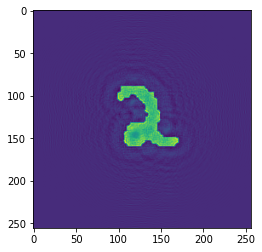

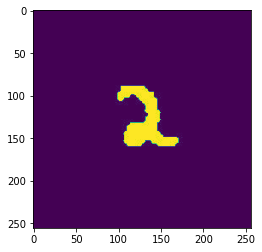

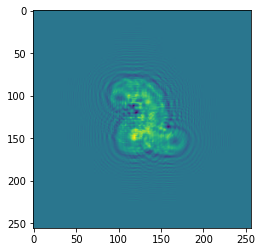

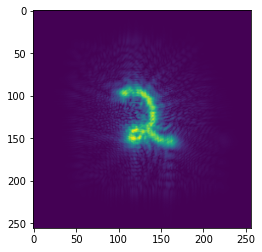

In [ ]:
i = 14
path = os.path.join(os.getcwd(),'data_set')
filename = '%03i.jpg'%i
reconstruction = rebuild_hologram(dic_holograms[filename])
plt.imshow(Image.open(os.path.join(path,filename)))
plt.show()
plt.imshow(abs(dic_holograms[filename]))
plt.show()
plt.imshow(abs(simulate(os.path.join(path,filename))))
plt.show()



Sus resultados estan bien en general

1. La imagen es muy grande, en general para generar el holograma queremos matrizes el doble de grandes que las imagenes. Es decir, cargan la imagen, y la "pegan" en una matriz del doble de tamaño. Esto permite que la luz se propage una mayor distancia preservando las condiciones de muestreo. Asi tambien se elimina los artifactos de difraccion que aprecian el algunas de las imagenes.

2. La intensidad de la onda plana debe ser mayor, tengan en cuenta que estan simulando dos campos opticos, por lo que si uno es muy intenso y el otro muy debil la interferencia no sera completamente constructiva ( o destructiva). Deben observarse franjas en la imagen.

3. Hay un error en la expresion que les di para la onda de referencia, ya lo corregi arriba la funcion. Faltaba dividir por el termino dx dentro del exponencial. Aun asi, por simplicidad, creo que sera mejor que hagan hologramas complejos, no de intensidad, para evitar la necesidad de la onda de referencia. En este caso, solo deben realizar la propagacion de la imagen. El campo resultante (sin sacar el modulo cuadrado) seria el holograma complejo. Para recuperar solo deben realizar la propagacion inversa.

4. Son imagenes muy complejas, para entrenar el algoritmo les recomiendo se limiten a algo simple, numeros, letras, etc. Para agilizar, usen imagenes de 100 pixeles y un espacio de 200 pixeles. Asi podran procesar muchas imagenes rapidamente.

Abajo les comparto el codigo modificado para este proceso

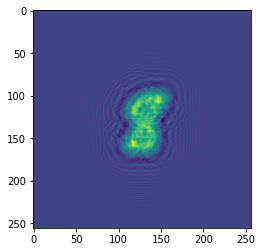

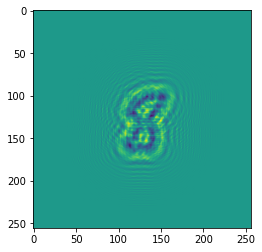

from folders:


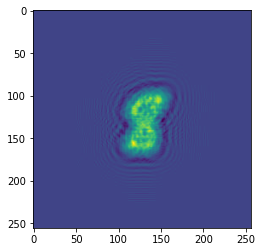

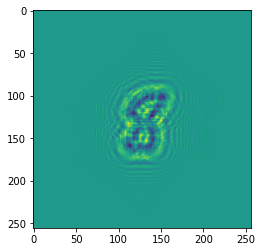

In [ ]:
i = 197
path = os.path.join(os.getcwd(),'data_set')
path1 = os.path.join(os.getcwd(),'hdata_set_R/')
path2 = os.path.join(os.getcwd(),'hdata_set_C/')


filename = '%03i.jpg'%i

himg = simulate(os.path.join(path,filename))   

himg_real = np.real(himg)
himg_complex = np.imag(himg)

plt.imshow(himg_real)
plt.show()
plt.imshow(himg_complex)
plt.show()
print('from folders:')
Himg_real = Image.open(os.path.join(path1,filename))
plt.imshow(Himg_real)
plt.show()

Himg_complex = Image.open(os.path.join(path2,filename))
plt.imshow(Himg_complex)
plt.show()


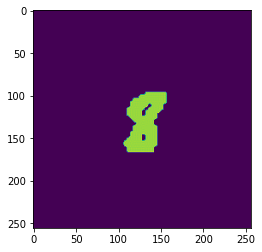

In [ ]:
U = np.asarray(himg_real) + 1j*np.asarray(himg_complex)
R = rebuild_hologram(U)

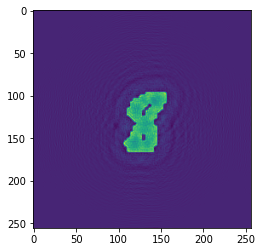

In [ ]:
U = np.asarray(Himg_real) + 1j*np.asarray(Himg_complex)
R = rebuild_hologram(U)

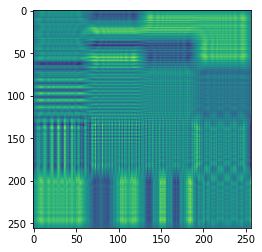

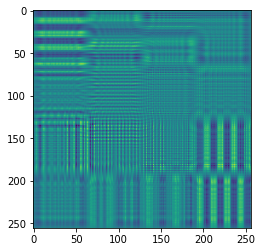

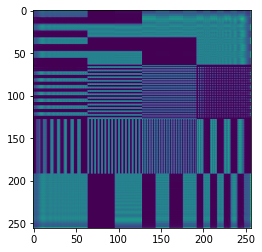

array([[148151.13334678,  65416.53628634,  69293.94260232, ...,
         62564.60138901,  65476.62561233, 127280.94146873],
       [ 63697.17502505,  30512.74961625,  29249.24336911, ...,
         28904.22921517,  25629.35233112,  57647.98939712],
       [ 68380.08197182,  28687.39326938,  32112.60590144, ...,
         26699.54030808,  29434.99787289,  53704.29230246],
       ...,
       [ 67620.04980811,  33031.7332866 ,  31084.25811876, ...,
         32368.63653513,  28106.72133715,  63346.02305516],
       [ 67758.34316923,  29204.5944753 ,  31880.75352893, ...,
         28310.83797856,  30172.29039358,  55764.03507601],
       [130315.35246487,  61784.47017085,  60076.96969985, ...,
         60669.60148122,  53333.68210754, 117394.88382889]])

In [ ]:
path = os.path.join(os.getcwd(),'samples/')
filename = '4q.bmp'
himg = simulate(os.path.join(path,filename))  
himg_real = np.real(himg)
himg_complex = np.imag(himg)

plt.imshow(himg_real)
plt.show()
plt.imshow(himg_complex)
plt.show()

rebuild_hologram(himg)